In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, cm
import pandas as pd
from adjustText import adjust_text

# Function definition

In [2]:
H = np.array([[3,0],[0,1]])

In [3]:
def f(z):
    return (z.T).dot(H).dot(z)

def df(z):
    return 2*H.dot(z)

def deltaf(z,u):
    """returns directional derivative of f along u"""
    return df(z).dot(u)/np.linalg.norm(u)

# ctrl+/ to comment/uncomment
# def projdf(z,U):
#     """returns directional derivative of f along U
#     U : (d,rank) matrix where each column is a direction"""
#     U_orth,_,_ = np.linalg.svd(U, full_matrices=False)
#     return U_orth.dot(U_orth.T.dot(H.dot(z)))

H = np.array([[3,0],[0,1]])
print("f(1,1) = 3*1^2+1^2 = ", f(np.array([1,1])))
print("df(1,1) = (6x,2y) = (6,2) = ", df(np.array([1,1])))
print("deltaf((1,1),(0,1)) = 2y = ", deltaf(np.array([1,1]), np.array([0,1])))

f(1,1) = 3*1^2+1^2 =  4
df(1,1) = (6x,2y) = (6,2) =  [6 2]
deltaf((1,1),(0,1)) = 2y =  2.0


# Plotting function

In [4]:
def show_trajs(Z1,Z2, title = "a plot", num = 5, savename = "", colorbar = True):
    """function is global variable
    works only for 2d plots
    num : number of dots numeroted"""
    ## Function as background
    xmin = -0.5
    xmax = 2
    N=100

    x1, x2 = np.meshgrid(np.linspace(xmin,xmax, num=N), np.linspace(xmin,xmax, num=N))
    coords = np.stack([x1,x2],axis=2)
    f_coords = np.apply_along_axis(f,2,coords)
    plt.figure(figsize=(7,7))
    plt.imshow(f_coords,extent=[xmin,xmax,xmin,xmax], cmap="jet", origin='lower') #cmap = cm.jet
    if colorbar : 
        plt.colorbar(shrink =0.7, ticks = [0,4,8,12,16])
        
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])
        
    ## Scatter trajectory
    Zs = [Z1, Z2]
    markers = ["x","o"]
    for k in [0,1]:
        Z = Zs[k]
        x = Z[:,0]
        y = Z[:,1]
        T = len(x)
        plt.scatter(x=x,y=y,color="white",marker=markers[k])
        for i, txt in enumerate(x):
            if i< num :
                plt.annotate(str(i), (x[i]+(-1)**k*0.1, y[i]),color="white",fontsize=10)
        #adjust_text(texts) --> see https://blog.finxter.com/matplotlib-text-and-annotate-a-simple-guide/

    plt.title(title)

    if (len(savename) > 2):
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

In [5]:
def show_traj(Z, title = "a plot", num = 5, savename = "", colorbar = True):
    """function is global variable
    works only for 2d plots
    num : number of dots numeroted"""
    ## Function as background
    xmin = -0.5
    xmax = 2
    N=100

    x1, x2 = np.meshgrid(np.linspace(xmin,xmax, num=N), np.linspace(xmin,xmax, num=N))
    coords = np.stack([x1,x2],axis=2)
    f_coords = np.apply_along_axis(f,2,coords)
    
    ## Scatter trajectory
    x = Z[:,0]
    y = Z[:,1]
    T = len(x)
    
    plt.figure(figsize=(7,7))
    plt.scatter(x=x,y=y,color="white",marker="x")
    plt.imshow(f_coords,extent=[xmin,xmax,xmin,xmax], cmap="jet", origin='lower') #cmap = cm.jet
    
    for i, txt in enumerate(x):
        if i< num :
            plt.annotate(str(i), (x[i]-0.1, y[i]),color="white",fontsize=10)
        #adjust_text(texts) --> see https://blog.finxter.com/matplotlib-text-and-annotate-a-simple-guide/
    

    plt.title(title)

    if (len(savename) > 2):
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

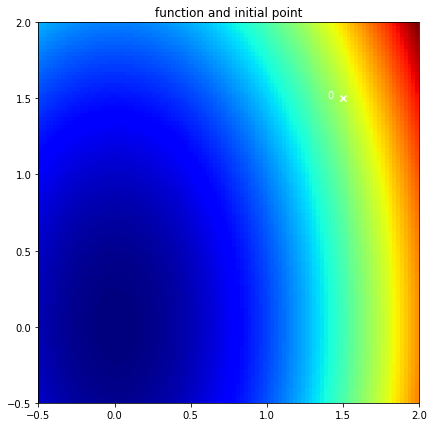

In [6]:
show_traj(np.array([[1.5,1.5]]), title = "function and initial point")

# Classic Gradient Descent

In [7]:
def GD(alpha = 0.1,z0 = np.array([1.5,1.5]), epsilon=0.1):
    Z = [z0]
    G = [df(z0)] 
    C = [0]
    
    while True: 
        zprev = Z[-1]
        gprev = G[-1]
        znext = zprev-alpha*gprev
        Z.append(znext)
        G.append(df(znext))
        C.append(len(z0))
        if np.linalg.norm(G[-1])<epsilon**(1/2):
            #STOPING CONDITION
            #Previous stopping was: f(zprev)-f(znext)<epsilon: 
            break

    return (np.array(Z),C)

oracle calls : 26
number of iterations : 14


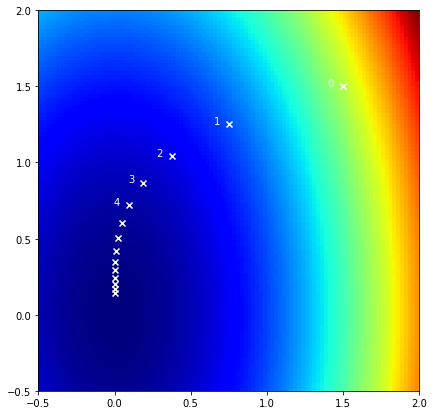

In [8]:
H = np.array([[3,0],[0,1]])
alpha = 1/12 # 1/6 would be optimal 
epsilon = 0.1

ZGD, CGD = GD(epsilon = epsilon, alpha = alpha) ## 1/6 would be optimal
print("oracle calls :", np.sum(CGD))
print("number of iterations :", len(ZGD))
show_traj(ZGD,title = "", savename = "GD.png", colorbar = False)

Text(0.5, 1.0, 'In log scale')

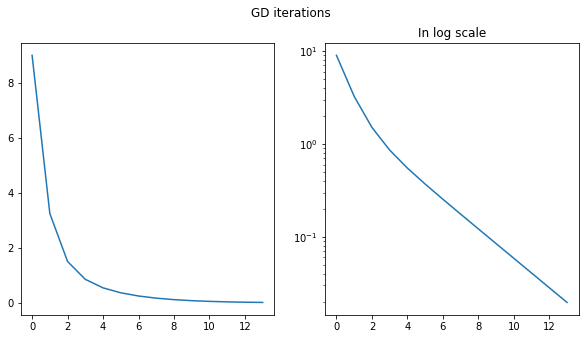

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('GD iterations')

ax1.plot([f(ZGD[i]) for i in range(len(ZGD))])

ax2.set_title("performance")
ax2.plot([f(ZGD[i]) for i in range(len(ZGD))])
ax2.set_yscale("log")
ax2.set_title("In log scale")

In [10]:
def LRGD(alpha = 0.1,z0 = np.array([1.5,1.5]), rank=1, epsilon=0.1):
    """a better implementation"""
    Z = [z0] # point
    G = [] # gradient
    C = [0] # oracle cost
    
    def GD_iter():
        #compute
        g = df(Z[-1])
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(len(z0))
    
    def LR_iter():
        #print("lr iter : ", len(Z))
        #print("current pos : ", Z[-1])
        
        #compute
        g = deltaf(Z[-1],G[-1])*G[-1]/np.linalg.norm(G[-1])
        #g = df(Z[-1]).dot(G[-1])/np.linalg.norm(G[-1])*G[-1]
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(rank)
        #print("next pos : ", Z[-1])
        
        
    GD_iter()
    
    while np.linalg.norm(G[-1]) > epsilon**(1/2): 
        #print("hi", np.linalg.norm(G[-1]))
        
        LR_iter()
        
        if np.linalg.norm(G[-1]) < epsilon**(1/2): 
        
            GD_iter()
    
    return (np.array(Z),C)

oracle calls :  25
number of iterations :  22


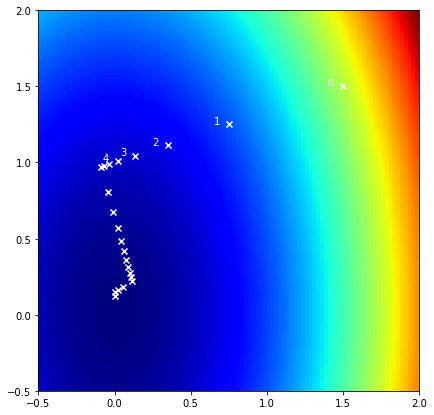

In [11]:
ZLRGD,CLRGD = LRGD(epsilon=0.1, alpha = alpha)
print("oracle calls : ", np.sum(CLRGD))
print("number of iterations : ", len(ZLRGD))
show_traj(ZLRGD,title = "", savename = "LRGD.pdf",colorbar = False)

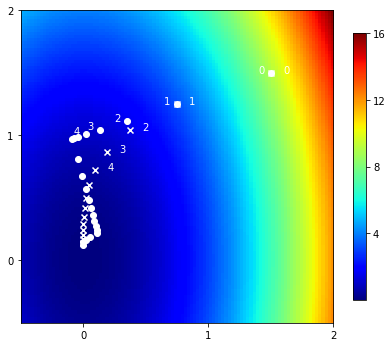

In [12]:
show_trajs(ZGD,ZLRGD,title = "", savename = "GD_LRGD.pdf",colorbar = True)

In [13]:
f(ZGD[-1])

0.019654968102330743

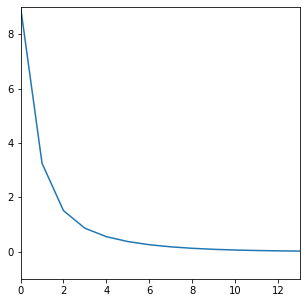

In [14]:
plt.subplots(figsize=(5, 5))
plt.xlim([0,13])
plt.ylim([-1,9])
plt.plot([f(ZGD[i]) for i in range(len(ZGD))])
plt.savefig("GD_iterations.pdf")

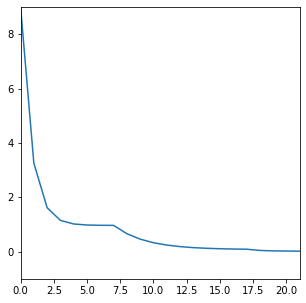

In [15]:
#### ENCAPSULATE THIS IN NICE PLOTS
plt.subplots(figsize = (5,5))

plt.xlim([0,21])
plt.ylim([-1,9])
plt.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])

for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax1.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)

plt.savefig("LRGD_iterations.pdf") 

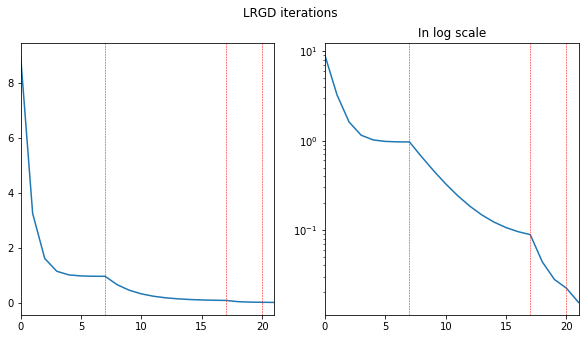

In [16]:
#### ENCAPSULATE THIS IN NICE PLOTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('LRGD iterations')

ax1.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax1.set_xlim(left = 0, right = len(ZLRGD)-1)

ax2.set_title("performance")
ax2.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax2.set_xlim(left = 0, right = len(ZLRGD)-1)
ax2.set_yscale("log")
ax2.set_title("In log scale")


for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax1.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        

(0, 13)

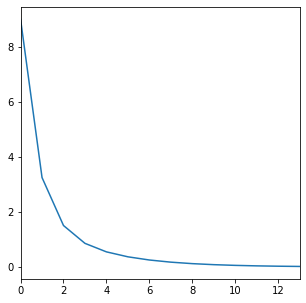

In [17]:
#### PLOT OF GD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZGD[i]) for i in range(len(ZGD))])
ax.set_xlim(left = 0, right = len(ZGD)-1)

(0, 21)

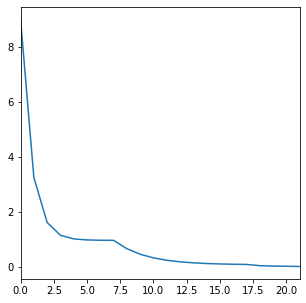

In [18]:
#### PLOT OF LRGD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = len(ZLRGD)-1)

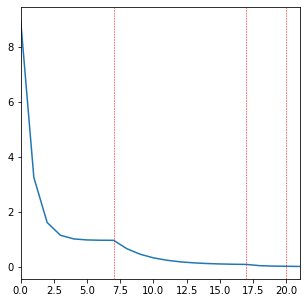

In [101]:
#### PLOT OF LRGD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = len(ZLRGD)-1)
for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)

(0, 25)

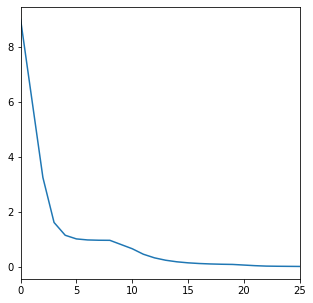

In [102]:
#### PLOT OF LRGD - by oracle call
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = np.sum(CLRGD))

(0, 26)

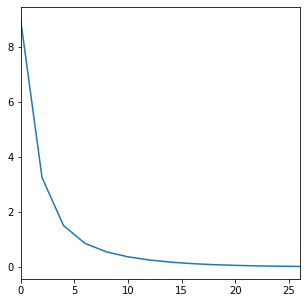

In [103]:
#### PLOT OF GD - by oracle call
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))])
ax.set_xlim(left = 0, right = np.sum(CGD))

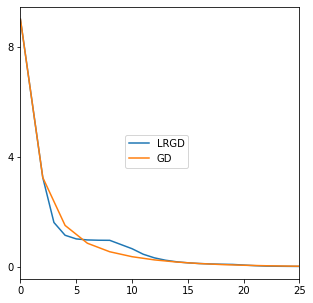

In [104]:
#### PLOT OF LRGD - by oracle call
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label ="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label = "GD")
ax.set_xlim(left = 0, right = np.sum(CLRGD))
fig.legend(loc="center")
plt.xticks([0,5,10,15,20,25])
plt.yticks([0,4,8])
plt.savefig("GD_LRGD_iterations.pdf")

In [105]:
### NOTE : could relate complexity of LRGD to complexity of Newton's method??? no -> but to complexity of line search. 


# Higher dimension

In [106]:
H = np.array(
    [[100,0,0],
     [0,10,0],
     [0,0,1]])

alpha = 1/100/10

In [107]:
ZGD,CGD = GD(z0 = np.array([1,1,1]),alpha = alpha, epsilon=0.01)
print("oracle calls : ", np.sum(CGD))

oracle calls :  4491


In [108]:
ZLRGD,CLRGD = LRGD(z0 = np.array([1,1,1]),alpha = alpha, epsilon=0.01)
print("oracle calls : ", np.sum(CLRGD))

oracle calls :  3022


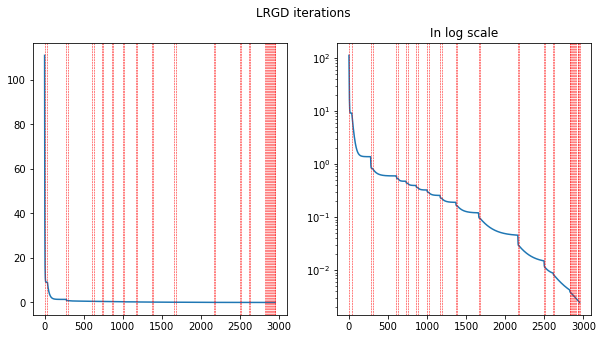

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('LRGD iterations')

ax1.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])

ax2.set_title("performance")
ax2.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax2.set_yscale("log")
ax2.set_title("In log scale")


for i,c in enumerate(CLRGD):
    if c>1: 
        ax1.axvline(x = i, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        

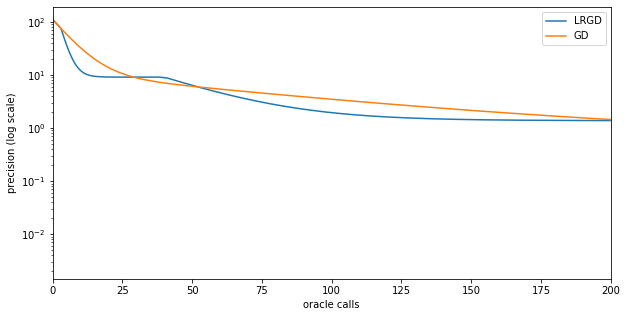

In [110]:
### TRANSPOSE !!!!!!!!!!!!!!

fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label="GD")
ax.set_yscale("log")
ax.set_ylabel("precision (log scale)")
ax.set_xlabel("oracle calls")
ax.set_xlim(left=0,right=200)
ax.legend()
fig.savefig("GDvsLRGD.png")

# More experiments

oracle calls GD :  14
oracle calls LRGD :  11


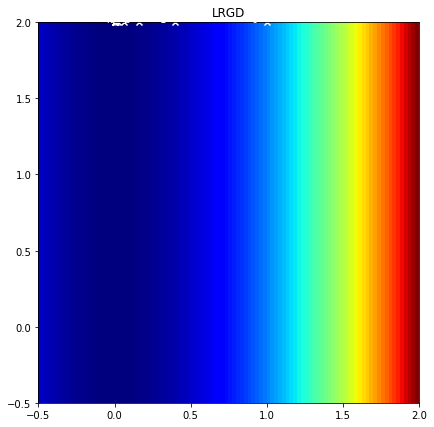

In [111]:
H = np.array(
    [[3,0],
     [0,0]])

z0 = np.array([1,2])

ZGD,CGD = GD(z0 = z0,epsilon=0.0001)
print("oracle calls GD : ", np.sum(CGD))

ZLRGD,CLRGD = LRGD(z0 = z0,epsilon=0.0001)
print("oracle calls LRGD : ", np.sum(CLRGD))

show_traj(ZLRGD,title = "LRGD")

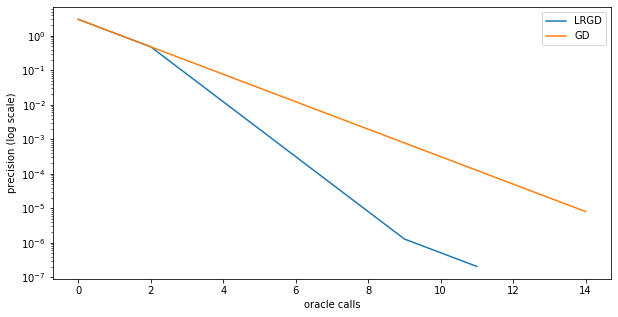

In [112]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label="GD")
ax.set_yscale("log")
ax.set_ylabel("precision (log scale)")
ax.set_xlabel("oracle calls")
ax.legend()
fig.savefig("GDvsLRGD.png")

# Large scale experiments

In [125]:
### NEED TO ADAPT LEARNING RATE
### alpha = 1/L where L is smoothness of gradient. i.e. max singular value


H1 = np.array([[1,0],
               [0,1]])

H2 = np.array([[10,0],
               [0,1]])

H3 = np.array([[100,0],
                [0,1]])

H4 = np.array([[1000,0],
                [0,1]])


Hs = [H1,H2,H3,H4]

alphas = np.array([1, 1/10, 1/100,1/1000])/2 #/2 is optimal

z0s = np.array([[1,0],
                [0.87,0.5], #sin(30)
                [0.71,0.71],#à peu près 1/sqrt(2)
                [0.5,0.87],
                [0,1]]) 

columns = [str(el) for el in Hs]
indices = [str(el) for el in z0s]
data_lrgd = np.zeros(shape = (len(indices),len(columns)))
data_gd = np.zeros(shape = (len(indices),len(columns)))
#zdata = {}

for j in range(len(Hs)): 
    for i in range(len(z0s)):
        H = Hs[j]
        ZLRGD,C = LRGD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
        data_lrgd[i,j] = np.sum(C)
        ZGD,C = GD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
        data_gd[i,j] = np.sum(C)
        #zdata[str(i)+","+str(j)]=ZLRGD.copy()

results_lrgd = pd.DataFrame(columns = columns,index = indices, data = data_lrgd)
results_gd = pd.DataFrame(columns = columns,index = indices, data = data_gd)

results_lrgd

,[[1 0] [0 1]],[[10 0] [ 0 1]],[[100 0] [ 0 1]],[[1000 0] [ 0 1]]
[1. 0.],5.0,5.0,5.0,5.0
[0.87 0.5 ],5.0,20.0,130.0,1190.0
[0.71 0.71],5.0,26.0,166.0,1536.0
[0.5 0.87],5.0,31.0,195.0,1746.0
[0. 1.],5.0,22.0,188.0,1848.0


In [126]:
results_gd

,[[1 0] [0 1]],[[10 0] [ 0 1]],[[100 0] [ 0 1]],[[1000 0] [ 0 1]]
[1. 0.],2.0,2.0,2.0,2.0
[0.87 0.5 ],2.0,22.0,230.0,2302.0
[0.71 0.71],2.0,30.0,300.0,3004.0
[0.5 0.87],2.0,34.0,340.0,3410.0
[0. 1.],2.0,36.0,368.0,3688.0


In [127]:
# INTERPRETATION
# dans les directions où le learning rate est trop bas (pcq le learning rate est conçu pour les directions les plus coûteuses)
# 

In [445]:
i = 1
j = 1
H = Hs[j]
ZLRGD,C = LRGD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
np.sum(C)

35

In [446]:
ZLRGD

array([[ 8.70000000e-01,  5.00000000e-01],
       [ 4.35000000e-01,  4.75000000e-01],
       [ 2.16855577e-01,  4.62462964e-01],
       [ 1.07460199e-01,  4.56175873e-01],
       [ 5.26004480e-02,  4.53023014e-01],
       [ 2.50893016e-02,  4.51441914e-01],
       [ 1.12929724e-02,  4.50649021e-01],
       [ 4.37436954e-03,  4.50251401e-01],
       [ 2.18718477e-03,  4.27738831e-01],
       [ 1.18562436e-04,  4.06446617e-01],
       [-1.83792447e-03,  3.86308607e-01],
       [-3.68835456e-03,  3.67262234e-01],
       [-5.43847694e-03,  3.49248323e-01],
       [-7.09372906e-03,  3.32210906e-01],
       [-8.65925364e-03,  3.16097049e-01],
       [-1.01399146e-02,  3.00856689e-01],
       [-1.15403122e-02,  2.86442475e-01],
       [-1.28647974e-02,  2.72809624e-01],
       [-1.41174851e-02,  2.59915779e-01],
       [-1.53022675e-02,  2.47720881e-01],
       [-1.64228254e-02,  2.36187041e-01],
       [-1.74826403e-02,  2.25278425e-01],
       [-1.84850051e-02,  2.14961141e-01],
       [-1.

In [447]:
ZLRGD

array([[ 8.70000000e-01,  5.00000000e-01],
       [ 4.35000000e-01,  4.75000000e-01],
       [ 2.16855577e-01,  4.62462964e-01],
       [ 1.07460199e-01,  4.56175873e-01],
       [ 5.26004480e-02,  4.53023014e-01],
       [ 2.50893016e-02,  4.51441914e-01],
       [ 1.12929724e-02,  4.50649021e-01],
       [ 4.37436954e-03,  4.50251401e-01],
       [ 2.18718477e-03,  4.27738831e-01],
       [ 1.18562436e-04,  4.06446617e-01],
       [-1.83792447e-03,  3.86308607e-01],
       [-3.68835456e-03,  3.67262234e-01],
       [-5.43847694e-03,  3.49248323e-01],
       [-7.09372906e-03,  3.32210906e-01],
       [-8.65925364e-03,  3.16097049e-01],
       [-1.01399146e-02,  3.00856689e-01],
       [-1.15403122e-02,  2.86442475e-01],
       [-1.28647974e-02,  2.72809624e-01],
       [-1.41174851e-02,  2.59915779e-01],
       [-1.53022675e-02,  2.47720881e-01],
       [-1.64228254e-02,  2.36187041e-01],
       [-1.74826403e-02,  2.25278425e-01],
       [-1.84850051e-02,  2.14961141e-01],
       [-1.

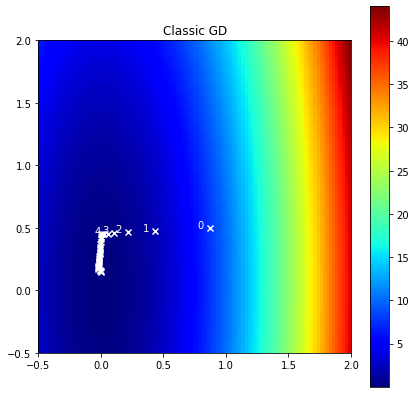

In [448]:
show_traj(ZLRGD,title = "Classic GD")

In [449]:
zdata['1,2']

NameError: name 'zdata' is not defined